## Generate LK-99 Paper Judgements

This notebook contains code that:
1. Loads a dataframe of LK-99 paper abstracts and metadata from a flat file. Calls the Gemini API to generate a judgment whether the paper supports, refutes, or is neutral to the hypothesis that LK-99 is a room temperature superconductor
2. Loops over that data to run a series of Bayesian updates on the likelihood of the hypothesis being true over time
3. Saves the generated data as a JSON file that the website can serve/visualize

#1: Load dataset of paper abstracts and classify them with Gemini

In [4]:
import requests
import json
import pandas as pd
import time # For adding delays
import sys # To use sys.exit() for "fail hard" behavior

# --- Configuration ---
# IMPORTANT: Replace "YOUR_GEMINI_API_KEY_HERE" with your actual Gemini API key.
API_KEY = "YOUR_GEMINI_API_KEY_HERE"
EXCEL_FILE_NAME = 'LK99_Data.xlsx'
HYPOTHESIS = 'LK-99 is a room-temperature superconductor.'
INIT_PROMPT = 'You are a hypothesis bot. You take a hypothesis along with a short paragraph. You respond with a single word: "yes" means the hypothesis is substantiated in the paragraph, "no" means the hypothesis is not substantiated in the short paragraph, or "neutral" if it cannot be determined whether the hypothesis is substantiated in the paragraph. You respond with exactly one word and one word only. You do not give any further explanation or context.'

# Few-shot example to reinforce the desired format
EXAMPLE_HYPOTHESIS = "Water boils at 100 degrees Celsius at standard atmospheric pressure."
EXAMPLE_STATEMENT = "When heated, water converts to steam at 100°C under normal conditions."
EXAMPLE_RESPONSE = "yes"

MAX_RETRIES_PER_ITEM = 3 # Maximum number of times to retry a *single* failed API call for an item
DELAY_BETWEEN_ITEM_RETRIES_SECONDS = 10 # Delay between retries for the *same* item
DELAY_BETWEEN_NEW_ITEMS_SECONDS = 3 # Delay before processing the *next* item in the list

# --- Helper Function for Gemini API Call (Consolidated Error Handling) ---
def call_gemini_api(api_key, init_prompt, example_hypothesis, example_statement, example_response, hypothesis, statement, index_for_logging):
    """
    Calls the Gemini API with the given prompt and statement.
    Returns the cleaned generated text on success, or None on any error.
    Consolidates all error handling into a single block for simplicity.
    """
    url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash-lite:generateContent?key=" + api_key
    headers = {'Content-Type': 'application/json'}
    data = {
        "contents": [
            {"parts": [{"text": init_prompt}], "role": "user"},
            {"parts": [{"text": f'Hypothesis: "{example_hypothesis}" Statement: "{example_statement}"'}], "role": "user"},
            {"parts": [{"text": example_response}], "role": "model"},
            {"parts": [{"text": f'Hypothesis: "{hypothesis}" Statement: "{statement}"'}], "role": "user"}
        ],
        "generation_config": {
            "temperature": 0.0,         # Make the output deterministic
            "max_output_tokens": 10     # Limit the response to a few tokens
        }
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(data), timeout=60)
        response.raise_for_status() # Raises HTTPError for 4xx/5xx status codes

        response_json = response.json()

        # Attempt to directly access the nested text. Any issue here (e.g., missing key,
        # malformed structure) will be caught by the generic 'except Exception'.
        generated_text = response_json['candidates'][0]['content']['parts'][0]['text']
        return generated_text.lower().replace('.','').replace(' ','')

    except Exception as e: # Catch any and all exceptions that occur during the API call or parsing
        print(f"Error: Index {index_for_logging} - API call or response parsing failed: {e}")
        # If it's a requests HTTP error, print relevant details
        if isinstance(e, requests.exceptions.RequestException) and hasattr(e, 'response') and e.response is not None:
            print(f"  Status: {e.response.status_code}, Content: {e.response.text[:100]}...")
        return None

# --- Main Execution (Single Loop with Individual Item Retries) ---
print(f"Loading data from {EXCEL_FILE_NAME}...")
try:
    df = pd.read_excel(EXCEL_FILE_NAME)
    if 'abstract' not in df.columns:
        raise ValueError(f"Column 'abstract' not found in {EXCEL_FILE_NAME}. Please ensure the Excel file has an 'abstract' column.")
    print(f"Successfully loaded {len(df)} rows.")
except FileNotFoundError:
    print(f"Error: The file '{EXCEL_FILE_NAME}' was not found. Please make sure it's in the correct directory.")
    sys.exit(1) # Exit with an error code
except Exception as e:
    print(f"Error loading Excel file: {e}")
    sys.exit(1) # Exit with an error code

all_lk99_responses = [] # This list will accumulate responses in order

print(f"\n--- Starting Processing of {len(df)} Items ---")

for i in range(len(df)):
    abs1 = df['abstract'][i]

    current_item_attempt = 0
    response_text = None # Initialize response for the current item's processing

    # Loop to retry the current item's API call
    while current_item_attempt <= MAX_RETRIES_PER_ITEM:
        if current_item_attempt > 0: # If it's a retry attempt, apply a delay
            print(f"  Retrying Index {i} (Attempt {current_item_attempt}/{MAX_RETRIES_PER_ITEM})...")
            time.sleep(DELAY_BETWEEN_ITEM_RETRIES_SECONDS)

        response_text = call_gemini_api(
            API_KEY, INIT_PROMPT, EXAMPLE_HYPOTHESIS, EXAMPLE_STATEMENT,
            EXAMPLE_RESPONSE, HYPOTHESIS, abs1, i # Pass index for logging
        )

        if response_text is not None: # If API call was successful for this item
            break # Exit the inner retry loop for this item

        current_item_attempt += 1

    # After exhausting retries for the current item, check if it succeeded
    if response_text is None:
        print(f"\n--- CRITICAL ERROR ---")
        print(f"Index {i}: Failed after {MAX_RETRIES_PER_ITEM} retries. Stopping processing prematurely.")
        sys.exit(1) # Stop the entire script

    else:
        all_lk99_responses.append(response_text)
        print(f"Index {i}: {response_text}")

    # Add the per-call delay before moving to the next item in the list
    if i < len(df) - 1: # Don't sleep after processing the very last item
        time.sleep(DELAY_BETWEEN_NEW_ITEMS_SECONDS)

# --- Finalizing and Assigning Results (if script completed) ---
# If the script reaches this point, it means all items were processed successfully
df['lk99_veracity'] = all_lk99_responses
df['lk99_veracity'] = df['lk99_veracity'].str.strip()

print("\n--- All items processed successfully! ---")
print("\nDataFrame with LK-99 veracity:")
print(df)

Loading data from LK99_Data.xlsx...
Successfully loaded 60 rows.

--- Starting Processing of 60 Items ---
Index 0: yes

Index 1: yes

Index 2: yes

Index 3: yes

Index 4: no

Index 5: no

Index 6: no

Index 7: neutral

Index 8: no

Index 9: neutral

Index 10: yes

Index 11: yes

Index 12: neutral

Index 13: no

Index 14: neutral

Index 15: neutral

Index 16: no

Index 17: no

Index 18: no

Index 19: yes

Index 20: neutral

Index 21: neutral

Index 22: no

Index 23: neutral

Index 24: no

Index 25: no

Index 26: no

Index 27: no

Index 28: neutral

Index 29: no

Index 30: no

Index 31: yes

Index 32: neutral

Index 33: yes

Index 34: yes

Index 35: no

Index 36: no

Index 37: no

Index 38: no

Index 39: neutral

Index 40: yes

Index 41: neutral

Index 42: neutral

Index 43: neutral

Index 44: neutral

Index 45: neutral

Index 46: yes

Index 47: neutral

Index 48: neutral

Index 49: yes

Index 50: no

Index 51: neutral

Index 52: no

Index 53: yes

Index 54: no

Index 55: no

Index 56: n

# 2: Record a process of updating our prior on whether the hypothesis holds

In [7]:
import datetime
import numpy as np

#MANIFOLD
betting_data = [[datetime.date(2023,7,26),0.25],
                [datetime.date(2023,7,27),0.20],
                [datetime.date(2023,7,28),0.20],
                [datetime.date(2023,7,29),0.18],
                [datetime.date(2023,7,30),0.15],
                [datetime.date(2023,7,31),0.30],
                [datetime.date(2023,8,1),0.60],
                [datetime.date(2023,8,2),0.39],
                [datetime.date(2023,8,3),0.34],
                [datetime.date(2023,8,4),0.37],
                [datetime.date(2023,8,5),0.35],
                [datetime.date(2023,8,6),0.40],
                [datetime.date(2023,8,7),0.37],
                [datetime.date(2023,8,8),0.17],
                [datetime.date(2023,8,9),0.16],
                [datetime.date(2023,8,10),0.16],
                [datetime.date(2023,8,11),0.13],
                [datetime.date(2023,8,12),0.13],
                [datetime.date(2023,8,13),0.12],
                [datetime.date(2023,8,14),0.12],
                [datetime.date(2023,8,15),0.11],
                [datetime.date(2023,8,16),0.10],
                [datetime.date(2023,8,31),0.08],
                [datetime.date(2023,9,30),0.06],
                [datetime.date(2023,10,31),0.04]]
betting_df = pd.DataFrame(np.array(betting_data),columns=['date','probability'])

In [8]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import norm

df = df.sort_values(by=['date'])
variances_list = [100]
means_list = [-90]
cdf_list = [0.5]

for i, row in df.iterrows():
    #Add means
    if row['lk99_veracity']=='yes':
        mean=1
    elif row['lk99_veracity']=='neutral':
        mean=0
    elif row['lk99_veracity']=='no':
        mean=-1
    #Add stdevs
    if type(row['journal_if']) is not float:
        variance=100
    else:
        journal_if_val = float(row['journal_if']) # Cast once
        if journal_if_val < 1: # Not a trusted journal
            variance=80
        elif journal_if_val < 5: # Semi-trusted journal (covers 1 to <5)
            variance=20
        else: # Well-respected journal (covers >=5)
            variance=10

    new_variance = 1./(1./variances_list[-1] + 1./variance)
    new_mean = new_variance * (means_list[-1]/variances_list[-1] + mean/variance)
    # print(row['lk99_veracity'],row['journal_if'],new_mean,new_variance)
    means_list.append(new_mean)
    variances_list.append(new_variance)
    cdf_list.append(1.0-norm.cdf(0,new_mean,new_variance))

df['means']=means_list[1:]
df['iter_variances']=variances_list[1:]
df['likelihood_adjusted']=cdf_list[1:]

import plotly.express as px
fig = px.line(df,x='date',y='likelihood_adjusted',hover_name='paper_title',hover_data=['doi','lk99_veracity','journal','journal_if','citations'],markers=True)
fig.add_scatter(x=betting_df['date'],y=betting_df['probability'])
fig.update_layout(title={'text':'Is LK-99 a Room-Temperature Superconductor?','font':{'size':30}})
fig.show()

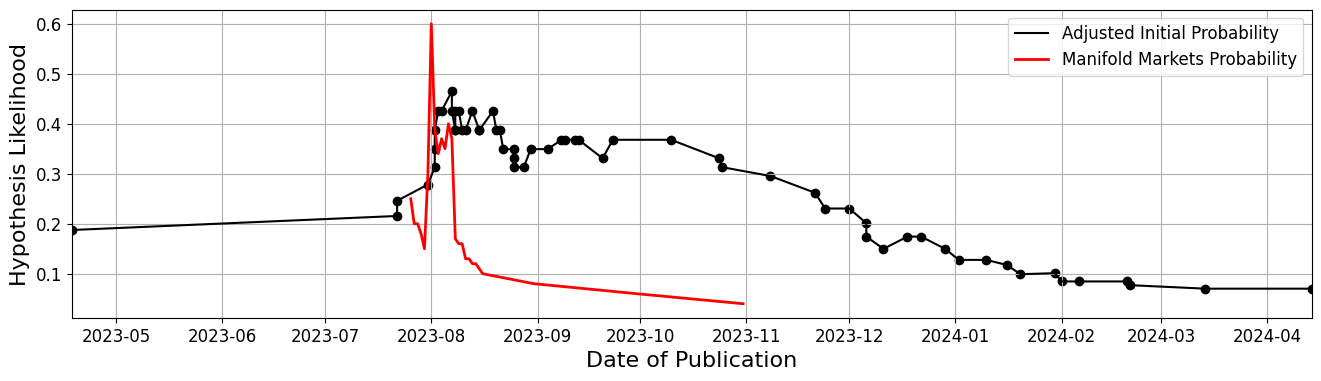

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
# plt.plot(df['date'],df['likelihood'],color='gray',label='Unadjusted Initial Probability')
# plt.scatter(df['date'],df['likelihood'],color='gray')
plt.plot(df['date'],df['likelihood_adjusted'],color='k',label='Adjusted Initial Probability')
plt.scatter(df['date'],df['likelihood_adjusted'],color='k')
plt.plot(betting_df['date'],betting_df['probability'],color='r',linewidth=2,label='Manifold Markets Probability')
plt.xlabel('Date of Publication',fontsize=16)
plt.ylabel('Hypothesis Likelihood',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([df['date'].tolist()[0],df['date'].tolist()[-1]])
plt.legend(fontsize=12)
plt.grid()
plt.show()

# 3: Export both dataframes as JSON for web visualization

In [ ]:
json_data = df.to_json(orient='records') # Use 'records' for a list of dictionaries

# Print or save the JSON data
json_data

'[{"paper_title":"Consideration for the development of room-temperature ambient-pressure superconductor (LK-99)","doi":"10.6111\\/JKCGCT.2023.33.2.061","journal":"Journal of the Korea Crystal Growth and Crystal Technology","journal_if":0.3,"citations":25,"date":1681776000000,"abstract":"This paper examines the way of thinking and limitations of physicists regarding the phenomenon of superconductivity and outlines how room-temperature and ambient-pressure superconductors can be developed through the statistical thermodynamic background of the liquid state theory. In hypothesis, the number of electron states should be limited by confining them to a state close to one-Dimension. Simultaneously, the electron-electron interactions should be frequent enough for the electrons to have liquid-like properties. As an example of implementing the hypothesis, our team reports the development of room-temperature and ambient-pressure superconductivity of a material named LK-99 (superconducting compoun

In [ ]:
betting_json_data = betting_df.to_json(orient='records') # Use 'records' for a list of dictionaries

# Print or save the JSON data
betting_json_data

'[{"date":1690329600000,"probability":0.25},{"date":1690416000000,"probability":0.2},{"date":1690502400000,"probability":0.2},{"date":1690588800000,"probability":0.18},{"date":1690675200000,"probability":0.15},{"date":1690761600000,"probability":0.3},{"date":1690848000000,"probability":0.6},{"date":1690934400000,"probability":0.39},{"date":1691020800000,"probability":0.34},{"date":1691107200000,"probability":0.37},{"date":1691193600000,"probability":0.35},{"date":1691280000000,"probability":0.4},{"date":1691366400000,"probability":0.37},{"date":1691452800000,"probability":0.17},{"date":1691539200000,"probability":0.16},{"date":1691625600000,"probability":0.16},{"date":1691712000000,"probability":0.13},{"date":1691798400000,"probability":0.13},{"date":1691884800000,"probability":0.12},{"date":1691971200000,"probability":0.12},{"date":1692057600000,"probability":0.11},{"date":1692144000000,"probability":0.1},{"date":1693440000000,"probability":0.08},{"date":1696032000000,"probability":0.